In [1]:
from policyengine_uk import Microsimulation
from policyengine_core.reforms import Reform
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
baseline = Microsimulation()
# reformed = Microsimulation(reform=reform)
baseline_income = baseline.calculate("real_household_net_income", period=2024)
# reformed_income = reformed.calculate("real_household_net_income", period=2029)
baseline_people = baseline.calculate("people", map_to = "household", period=2024)
# reformed_people = baseline.calculate("people", map_to = "household", period=2029)

In [3]:
def get_income_data():
    constituencies = pd.read_csv("../policyengine_uk_local_areas/constituencies_2024.csv")
    hex_locations = pd.read_csv("../policyengine_uk_local_areas/hex_map/hex_map_2024.csv")
    
    with h5py.File("../constituencies/weights.h5", "r") as f:
        weights = f["weight"][:]
    
    mapping_matrix = pd.read_csv("../mapping_2010_to_2024/mapping_matrix.csv")
    mapping_matrix = mapping_matrix.set_index(mapping_matrix.columns[0])
    mapping_matrix = mapping_matrix.div(mapping_matrix.sum(), axis=1)
    
    weights_2024 = mapping_matrix.T.dot(weights)
    
    # Calculate income and population for 2024 only
    income_2024 = np.dot(weights_2024, baseline_income.values)
    population_2024 = np.dot(weights_2024, baseline_people.values)
    
    # Calculate per capita income for 2024
    per_capita_2024 = income_2024 / population_2024
    
    df = pd.DataFrame({
        'code': mapping_matrix.columns,
        'income': per_capita_2024
    })
    df = df.merge(constituencies[['code', 'name']], on='code', how='left')
    merged_df = pd.merge(df, hex_locations, on='code', how='inner')
    
    return merged_df

# Get the data
data = get_income_data()

data.x = data.x + (data.y % 2 == 0) * 0.5

# Create the interactive plot
fig = go.Figure()

# Add hexagons
fig.add_trace(go.Scatter(
    x=data['x'],
    y=data['y'],
    mode='markers',
    marker=dict(
        size=13.8,
        color=data['income'],
        colorscale='OrRd',
        symbol='hexagon',
        line=dict(color='white', width=0.5),
        colorbar=dict(
            title=dict(
                text='Per capita household real net income (£)',
                side='bottom',
                font=dict(size=12)
            ),
            orientation='h',
            y=-0.15,
            xanchor='center',
            x=0.5,
            thickness=10,
            len=0.5,
            nticks=7,  # Reduced number of ticks
            tickangle=0  # Rotate the tick labels
            # tickformat=',.0f',  # Format as thousands with comma
            # tickprefix='£'  # Add pound symbol
        )
    ),
    hovertemplate=
    '<b>Constituency:</b> %{text}<br>' +
    '<b>Income:</b> £%{marker.color:,.0f}<br>' +
    '<extra></extra>',  # removes secondary box
    text=data['name']
))

# Update layout
fig.update_layout(
    title=dict(
        text='Per capita household real net income by constituency (2024)',
        x=0.5,
        y=0.95,
        xanchor='center',
        yanchor='top'
    ),
    paper_bgcolor='white',
    plot_bgcolor='#f0f0f0',
    showlegend=False,
    width=800,
    height=800,
    xaxis=dict(
        showgrid=False,
        showticklabels=False,
        zeroline=False
    ),
    yaxis=dict(
        showgrid=False,
        showticklabels=False,
        zeroline=False,
        scaleanchor='x',
        scaleratio=1
    )
)

# Show the plot
fig.show()

In [4]:
constituency_lad = pd.read_csv("Constituency_to_LAD(2024).csv", 
                             usecols=['PCON24CD', 'PCON24NM', 'LAD24CD', 'LAD24NM'])
constituency_lad.head()

,PCON24CD,PCON24NM,LAD24CD,LAD24NM
0,E14001272,Hartlepool,E06000001,Hartlepool
1,E14001272,Hartlepool,E06000001,Hartlepool
2,E14001272,Hartlepool,E06000001,Hartlepool
3,E14001272,Hartlepool,E06000001,Hartlepool
4,E14001272,Hartlepool,E06000001,Hartlepool


In [5]:
# Merge the dataframes
result = data.merge(constituency_lad, 
                   left_on='code',    # from data dataframe
                   right_on='PCON24CD',  # from constituency_lad
                   how='left')

# Display info to verify the merge
print("Original data shape:", data.shape)
print("constituency_lad shape:", constituency_lad.shape)
print("Result shape:", result.shape)

# Check for any unmatched rows
unmatched = result[result['PCON24CD'].isna()]
if len(unmatched) > 0:
    print("\nNumber of unmatched rows:", len(unmatched))
    print("Sample of unmatched codes:")
    print(unmatched['code'].head())

# Show first few rows and columns
print("\nFirst few rows of merged result:")
result.head()

Original data shape: (650, 5)
constituency_lad shape: (8798, 4)
Result shape: (8798, 9)

First few rows of merged result:


,code,income,name,x,y,PCON24CD,PCON24NM,LAD24CD,LAD24NM
0,E14001063,23038.553717,Aldershot,56.5,-40,E14001063,Aldershot,E07000092,Rushmoor
1,E14001063,23038.553717,Aldershot,56.5,-40,E14001063,Aldershot,E07000092,Rushmoor
2,E14001063,23038.553717,Aldershot,56.5,-40,E14001063,Aldershot,E07000092,Rushmoor
3,E14001063,23038.553717,Aldershot,56.5,-40,E14001063,Aldershot,E07000092,Rushmoor
4,E14001063,23038.553717,Aldershot,56.5,-40,E14001063,Aldershot,E07000092,Rushmoor


In [6]:
lad_income = result.groupby(['LAD24CD', 'LAD24NM'])['income'].mean().reset_index()
lad_income.head()

,LAD24CD,LAD24NM,income
0,E06000001,Hartlepool,14037.783074
1,E06000002,Middlesbrough,14687.359761
2,E06000003,Redcar and Cleveland,15224.669602
3,E06000004,Stockton-on-Tees,15093.184476
4,E06000005,Darlington,14858.934621


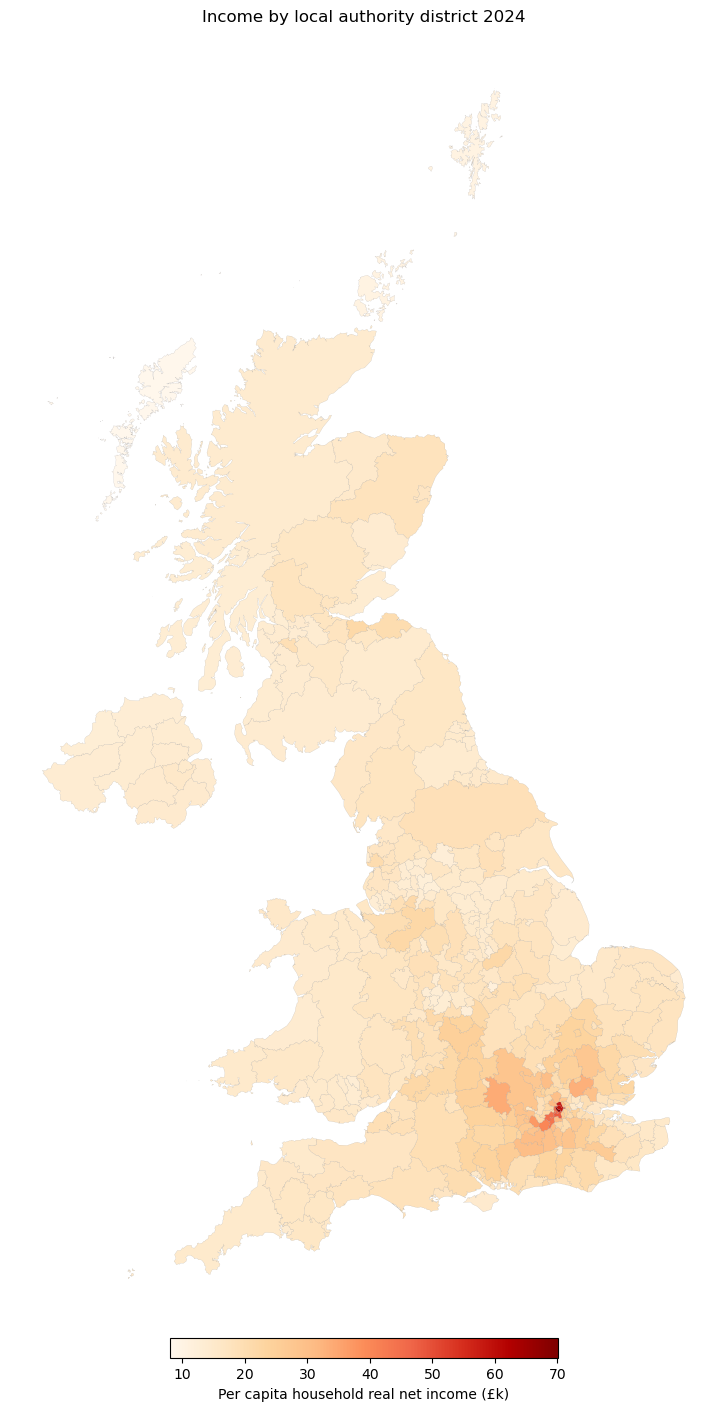

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import os

# Path to the zip file
zip_file_path = "Local_Authority_2024_Boundaries.zip"

# Extract the zip file
extracted_folder = "extracted_shapefile"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Find the .shp file in the extracted folder
shapefile_path = None
for root, dirs, files in os.walk(extracted_folder):
    for file in files:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)
            
if shapefile_path:
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Assume lad_income is already defined with actual data
    # lad_income = pd.DataFrame(data)
    
    lad_income_copy = lad_income.copy()  # Create a copy of the lad_income DataFrame
    lad_income_copy['income'] = lad_income_copy['income'] / 1000  # Convert to thousands

    # Merge GeoDataFrame with income data
    merged_gdf = gdf.merge(lad_income_copy, on="LAD24CD", how="left")

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    merged_gdf.plot(
        column="income", 
        cmap="OrRd", 
        linewidth=0.08, 
        ax=ax, 
        edgecolor="0.5", 
        legend=True,
        legend_kwds={
            'orientation': 'horizontal',  # Set legend orientation to horizontal
            'shrink': 0.5,                # Adjust size of the legend
            'pad': 0.0,                   # Add space between the legend and map
            'label': 'Per capita household real net income (£k)'  # Add a label for the legend
        }
    )
    ax.axis('off')  # Remove axes
    plt.title("Income by local authority district 2024")
    plt.show()
else:
    print("No shapefile (.shp) found in the ZIP archive.")
